In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib qt

In [2]:
# prepare object points
nx = 9#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y 
#images = glob.glob('../camera_cal/calibration*.jpg')
img_dir_camera_cal = 'camera_cal/'
img_dir_road_img = 'test_images/'
#img = mpimg.imread('camera_cal/calibration1.jpg')

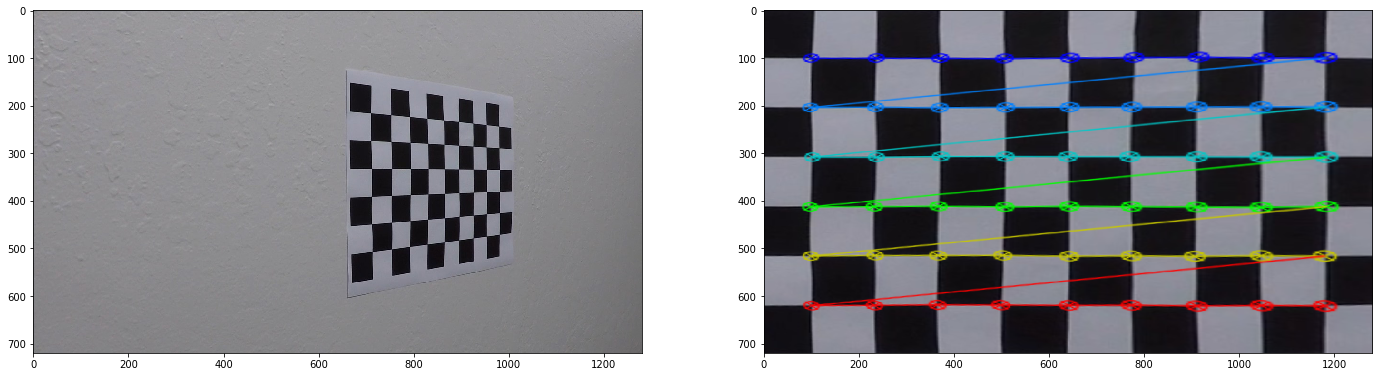

In [3]:
# get the camera cal done
for img in os.listdir(img_dir_camera_cal):
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    # OR you can retrieve the points from img
    img = mpimg.imread(img_dir_camera_cal+img)
    objpoints = []
    imgpoints = []
    objp = np.zeros((nx*ny,3),np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) #XY coordinates
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
    if (len(imgpoints) & len(objpoints)) != 1:
        continue

    ###########################################################
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)# use the undist img to find the new corners/gray
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    ###########################################################
    gray = cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY)# use the undist img to find the new corners/gray
    # 2) Convert to grayscale
    # 3) Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    # 4) If corners found: 
            # a) draw corners
            # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
                 #Note: you could pick any four of the detected corners 
                 # as long as those four corners define a rectangle
                 #One especially smart way to do this would be to use four well-chosen
                 # corners that were automatically detected during the undistortion steps
                 #We recommend using the automatic detection of corners in your code
    if ret == True: 
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        offset = 100 # offset for dst points
        img_size = gray.shape[::-1] # use gray.shape[::-1] since we only need 2-dim for gray scale 

        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]]) # 0-7 -last one -last 8th
            # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])            
            # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
            # e) use cv2.warpPerspective() to warp your image to a top-down view
        warped = cv2.warpPerspective(undist, M, img_size)
######## Uncomment for img testing ############### ########### ###############
fig = plt.figure(figsize=(24,12))
fig.add_subplot(1,2, 1)
plt.imshow(img)
fig.add_subplot(1,2, 2)
plt.imshow(warped)
plt.savefig('output_images/'+'output' + 'calibration8')

In [4]:
# get the camera cal done
def get_camer_cal(img):
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    # OR you can retrieve the points from img
    img = mpimg.imread(img)
    objpoints = []
    imgpoints = []
    objp = np.zeros((nx*ny,3),np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) #XY coordinates
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)# use the undist img to find the new corners/gray
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist

In [5]:
def undist_image(img, mtx, dist):
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        return undist

In [6]:
def persp_transf(undist,src,dst):
    h,w = undist.shape[:2]
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
        # e) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(undist, M, (w,h))
    return warped,M,M_inv

In [7]:
def abs_sobel_thresh(img, orient='x', thresh_min = 0, thresh_max = 255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sxbinary = np.zeros_like(scaled_sobel)  
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    binary_output = sxbinary
    return binary_output

In [8]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) #smooth out
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

In [9]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) #smooth out
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    mask_binary = np.zeros_like(grad_dir) #use x-sobel
    mask_binary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = mask_binary # Remove this line
    return binary_output

In [10]:
def color_select(img, thresh_s=(0, 255),thresh_v=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    S = hls[:,:,2]
    V = hsv[:,:,2]
    # 2) Apply a threshold to the S channel
    s_binary = np.zeros_like(S)
    s_binary[(S > thresh_s[0]) & (S <= thresh_s[1])] = 1
    v_binary = np.zeros_like(V)
    v_binary[(V > thresh_v[0]) & (V <= thresh_v[1])] = 1
    binary_output = np.zeros_like(S)
    binary_output[(s_binary == 1) & (v_binary == 1)] = 1
    # 3) Return a binary image of threshold result
    return binary_output

In [11]:
def fit_lines(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint #midpoint - just one point 

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 10
    # Set the width of the windows +/- margin
    margin = 80 #Note 这个window框住了才能采到点
    # Set minimum number of pixels found to recenter window
    minpix = 40 #Work like a filter 

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base #just one point- mid point 
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this leftx_current is the detected hist center point, margin represent the window size
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        # limits above just one point - mid point 
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###inbetween ylow/high and xlow/high

        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0] 
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds) #append one more mid point 
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ### out of the frame box 
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        # recenter the window every 50 points 

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] # The size of it depends on the #of detected pixels 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] #  so leftx,rightx and ploty will not be the same size for now

    ###############################################
    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    ### First ploy created here ######
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    ###############################
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    ##search_around_poly
    margin = 80
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[lefty, leftx] = [255, 0, 0] #Mark the valid/used line pixel points 
    out_img[righty, rightx] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, # v(vertical)stack -> merge two seperate arry 
                              ploty])))])# Flipud -> flip array up to down 
    left_line_pts = np.hstack((left_line_window1, left_line_window2))#h(horizontal)stack
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))


    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    ploy_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    cv2.polylines(ploy_img, np.int32([pts_left]), isClosed=False, color=(255,255,0), thickness=5)
    cv2.polylines(ploy_img, np.int32([pts_right]), isClosed=False, color=(255,255,0), thickness=5)

    
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    
    ## End visualization steps ##
    #combo = cv2.addWeighted(ploy_img, 0.8, ploy_line, 1, 0) 

    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # 30m for 720 pixels 
    xm_per_pix = 3.7/750 # 3.7m for 750 pixels 
    
    # New x,y pixel -> meter
    leftx = leftx*xm_per_pix
    rightx = rightx*xm_per_pix
    lefty = lefty*ym_per_pix
    righty = righty*ym_per_pix
    
    
    ##### Utilize `ym_per_pix` & `xm_per_pix` here #####
    left_fit_cr = np.polyfit(lefty, leftx, 2)
    right_fit_cr = np.polyfit(righty, rightx, 2)
   
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = (1+(2*left_fit[0]*y_eval+left_fit[1])**2)**(3/2)/np.absolute(2*left_fit[0])  ## Implement the calculation of the left line here A -> left_fit[0] ...
    right_curverad = (1+(2*right_fit[0]*y_eval+right_fit[1])**2)**(3/2)/np.absolute(2*right_fit[0])    ## Implement the calculation of the right line here
    
    ####Car position####
    car_position_ref = ploy_img.shape[1]/2
    
    l_line_start  = left_fit[0]*ploy_img.shape[0]**2 + left_fit[1]*ploy_img.shape[0] + left_fit[2]
    r_line_start  = right_fit[0]*ploy_img.shape[0]**2 + right_fit[1]*ploy_img.shape[0] + right_fit[2]
    
    car_position_cur = (l_line_start + r_line_start) / 2
    center_error = (car_position_ref - car_position_cur) * xm_per_pix
    
    return ploy_img, left_curverad, right_curverad, left_fit, right_fit , center_error



In [12]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,255,0), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(255,255,0), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

In [13]:
def hud(line_img, left_curverad, right_curverad , center_error):
    new_img = np.copy(line_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Radius of curvature left:' + '{:04.2f}'.format(left_curverad) + 'm' 
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    text = 'Radius of curvature right:' + '{:04.2f}'.format(right_curverad) + 'm' 
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    if center_error > 0:
            text = 'Car' + '{:04.2f}'.format(abs(center_error)) + 'm right' 
    elif center_error < 0:
            text = 'Car' + '{:04.2f}'.format(abs(center_error)) + 'm left'  
    cv2.putText(new_img, text, (40,170), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

In [14]:
def Binary_pipeline(img):
    # HLS
    # Threshold x gradient
    color_binary = color_select(img, thresh_s=(100, 255),thresh_v=(150,255))
    grad_binary = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100)
    mag_binary = mag_thresh(img, sobel_kernel=5, mag_thresh=(50, 120))
    dir_binary = dir_threshold(img, sobel_kernel=1, thresh=(0.03, 0.3))
    combined = np.zeros_like(mag_binary)
    combined[((color_binary == 1) | (grad_binary == 1) & (mag_binary == 1) & (dir_binary == 1) )] = 1
    #噪音多的用&，图像明确的用|
    return combined

In [15]:
def all_pipeline(img):
    # undistortion and perspective transform
    undist = undist_image(img, mtx, dist)
    h,w = undist.shape[:2]
    src = np.float32([(0.42*w,0.67*h),
                  (0.61*w,0.67*h),
                  (0.17*w,0.95*h),
                  (0.88*w,0.95*h)])#low high low high
    dst_offset = 250;
    dst = np.float32([(dst_offset,0),
                      (w-dst_offset,0),
                      (dst_offset,h),
                      (w-dst_offset,h)])
    warped,M,M_inv = persp_transf(undist,src,dst)
    # Binarized image
    binary_warped = Binary_pipeline(warped)
    # Get polyfitting
    polyfit_img,left_curverad,right_curverad, left_fit, right_fit,center_error = fit_lines(binary_warped)
    # Draw line image 
    line_img = draw_lane(img, binary_warped, left_fit, right_fit, M_inv);
    # Draw roc 
    hub_img = hud(line_img, left_curverad, right_curverad,center_error);
    return binary_warped,polyfit_img,hub_img

In [16]:
def video_pipeline(img):
    # undistortion and perspective transform
    undist = undist_image(img, mtx, dist)
    h,w = undist.shape[:2]
    src = np.float32([(0.42*w,0.67*h),
                  (0.61*w,0.67*h),
                  (0.17*w,0.95*h),
                  (0.88*w,0.95*h)])#low high low high
    dst_offset = 250;
    dst = np.float32([(dst_offset,0),
                      (w-dst_offset,0),
                      (dst_offset,h),
                      (w-dst_offset,h)])
    warped,M,M_inv = persp_transf(undist,src,dst)
    # Binarized image
    binary_warped = Binary_pipeline(warped)
    # Get polyfitting
    polyfit_img,left_curverad,right_curverad, left_fit, right_fit,center_error = fit_lines(binary_warped)
    # Draw line image 
    line_img = draw_lane(img, binary_warped, left_fit, right_fit, M_inv);
    # Draw roc 
    hub_img = hud(line_img, left_curverad, right_curverad,center_error);
    #fig = plt.figure(figsize=(24,12))
    #fig.add_subplot(1,3, 1)
    #plt.imshow(binary_warped)
    #fig.add_subplot(1,3, 2)
    #plt.imshow(polyfit_img)
    #fig.add_subplot(1,3, 3)
    #plt.imshow(hub_img)
    #plt.show()
    return hub_img

[[  537.59997559   482.3999939 ]
 [  780.79998779   482.3999939 ]
 [  217.6000061    684.        ]
 [ 1126.40002441   684.        ]]
[[  250.     0.]
 [ 1030.     0.]
 [  250.   720.]
 [ 1030.   720.]]


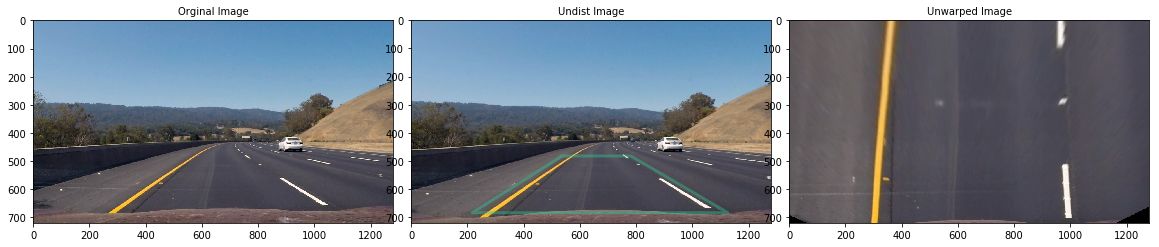

In [17]:
# camera cal 
mtx, dist = get_camer_cal('camera_cal/calibration2.jpg')
# undistort image
img = mpimg.imread('test_images/test3.jpg')
undist = undist_image(img, mtx, dist)
# perspective transform
h,w = undist.shape[:2]
src = np.float32([(0.42*w,0.67*h),
                  (0.61*w,0.67*h),
                  (0.17*w,0.95*h),
                  (0.88*w,0.95*h)])#low high low high
dst_offset = 250;
dst = np.float32([(dst_offset,0),
                  (w-dst_offset,0),
                  (dst_offset,h),
                  (w-dst_offset,h)])
warped,M,M_inv = persp_transf(undist,src,dst)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Orginal Image', fontsize=10)
ax2.imshow(undist)
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax2.plot(x, y, color='#33cc99', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax2.set_ylim([h,0])
ax2.set_xlim([0,w])
ax2.set_title('Undist Image', fontsize=10)
ax3.imshow(warped)
ax3.set_title('Unwarped Image', fontsize=10)
plt.savefig('output_images/'+'output'+'test3_undist')
print(src)
print(dst)


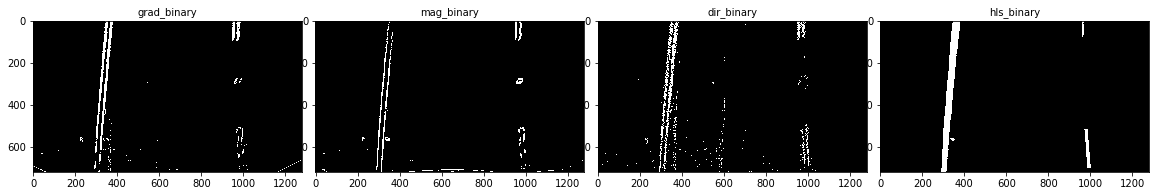

In [18]:
#Gradient and color
grad_binary = abs_sobel_thresh(warped, orient='x', thresh_min=20, thresh_max=100)
mag_binary = mag_thresh(warped, sobel_kernel=3, mag_thresh=(30, 100))
dir_binary = dir_threshold(warped, sobel_kernel=1, thresh=(0.03, 0.3))
color_binary = color_select(warped, thresh_s=(60, 255),thresh_v=(120,255))

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(grad_binary,cmap='gray')
ax1.set_title('grad_binary', fontsize=10)
ax2.imshow(mag_binary,cmap='gray')
ax2.set_title('mag_binary', fontsize=10)
ax3.imshow(dir_binary,cmap='gray')
ax3.set_title('dir_binary', fontsize=10)
ax4.imshow(color_binary,cmap='gray')
ax4.set_title('hls_binary', fontsize=10)
plt.savefig('output_images/'+'output' + 'Binary_test03')

Text(0.5,1,'Image after polyfitting')

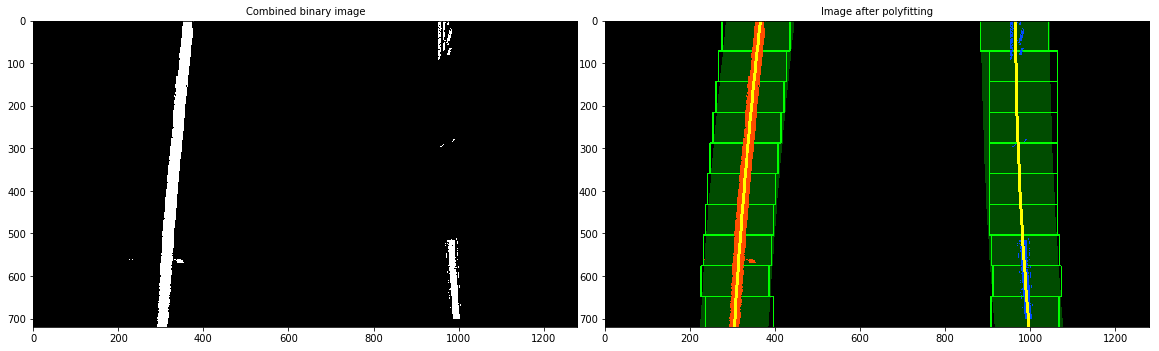

In [19]:
#Combine the binary images
binary_warped = Binary_pipeline(warped)
polyfit_img,left_curverad,right_curverad, left_fit, right_fit,center_error = fit_lines(binary_warped)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(binary_warped,cmap='gray')
ax1.set_title('Combined binary image', fontsize=10)
ax2.imshow(polyfit_img)
ax2.set_title('Image after polyfitting', fontsize=10)

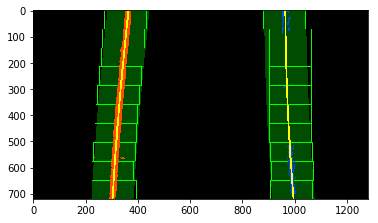

In [20]:
# Poly fit
polyfit_img,left_curverad,right_curverad,left_fit, right_fit,center_error= fit_lines(binary_warped)
plt.imshow(polyfit_img)

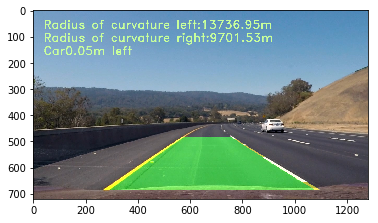

In [21]:
line_img = draw_lane(img, binary_warped, left_fit, right_fit, M_inv);
hub_img = hud(line_img, left_curverad, right_curverad,center_error);
plt.imshow(hub_img)
plt.savefig('output_images/'+'output'+'test3.jpg')

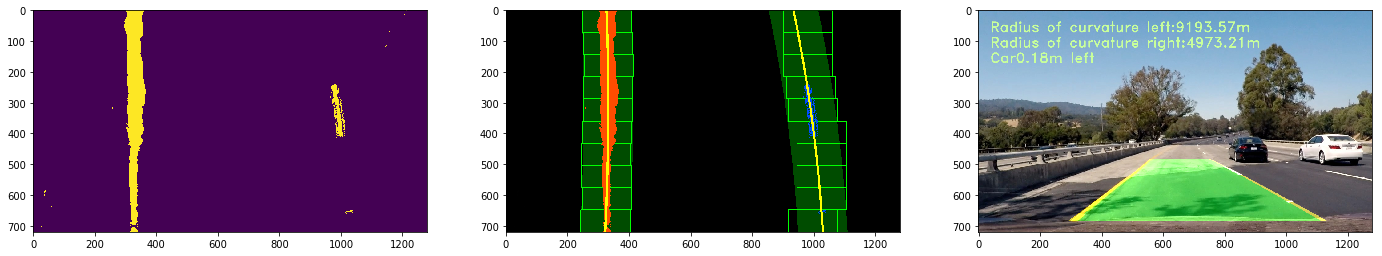

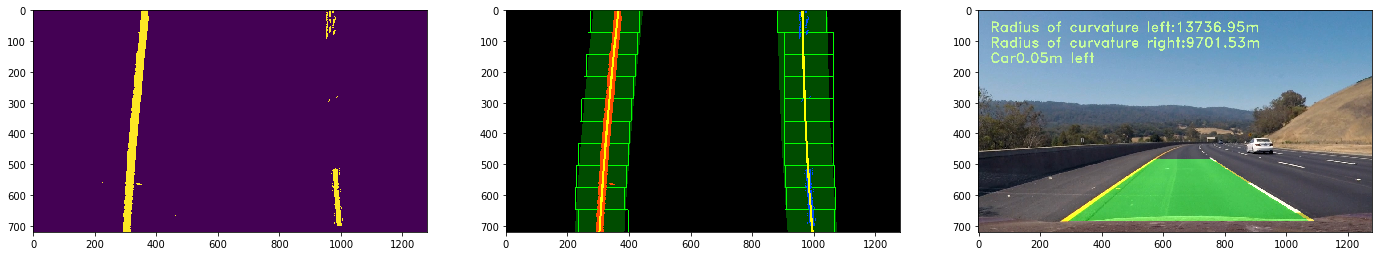

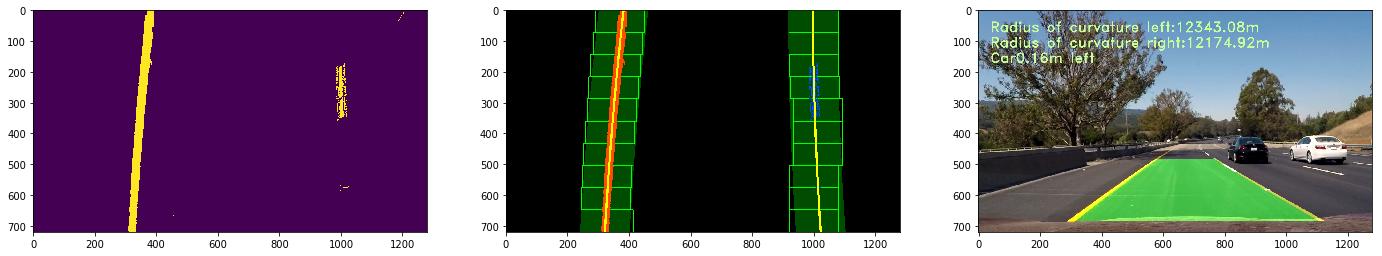

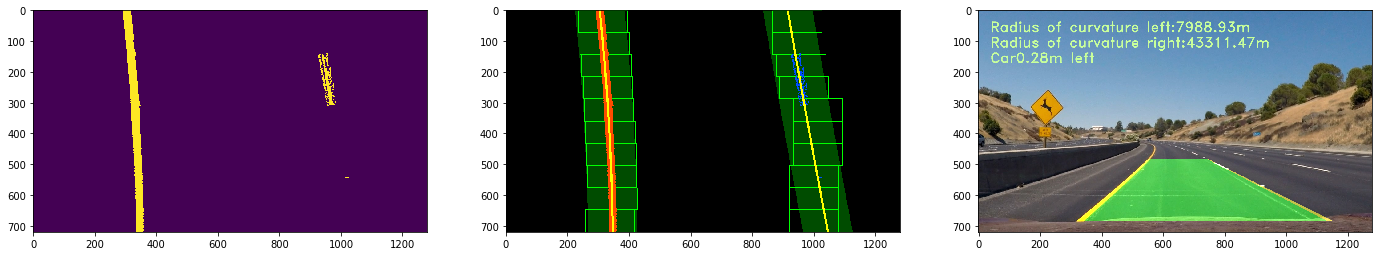

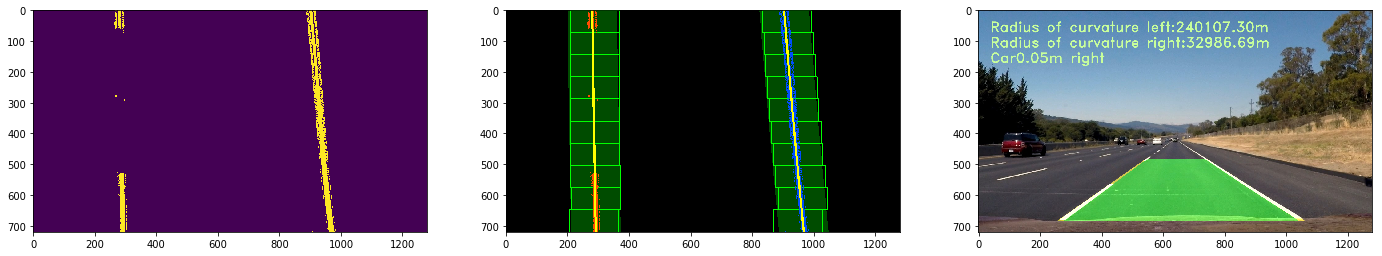

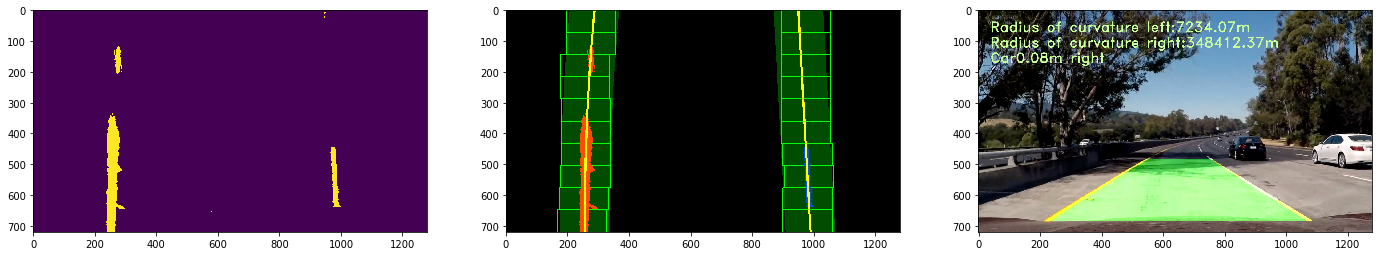

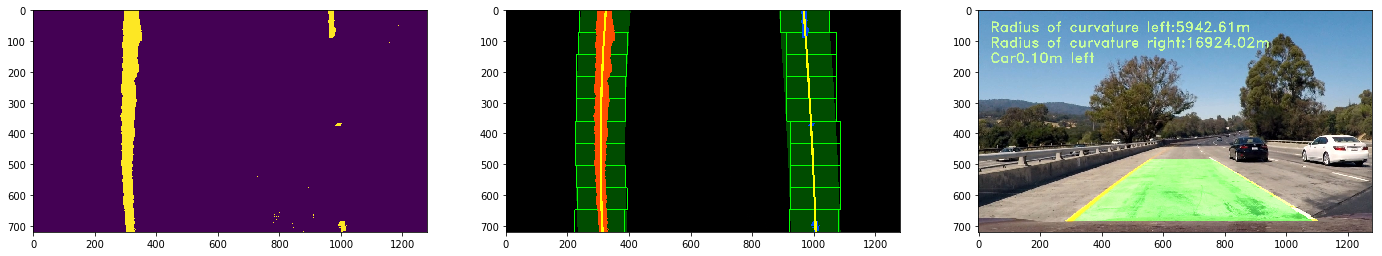

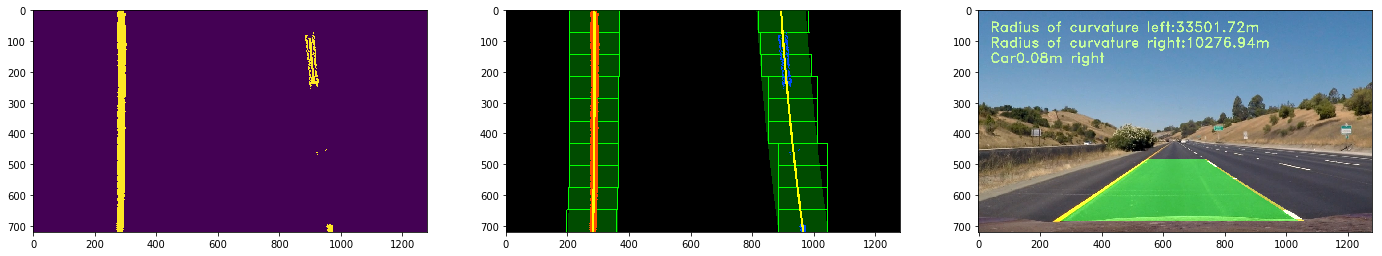

In [22]:
import os
for img in os.listdir(img_dir_road_img):
    image = mpimg.imread(img_dir_road_img+img)
    binary_warped,polyfit_img,hub_img = all_pipeline(image)
    fig = plt.figure(figsize=(24,12))
    fig.add_subplot(1,3, 1)
    plt.imshow(binary_warped)
    fig.add_subplot(1,3, 2)
    plt.imshow(polyfit_img)
    fig.add_subplot(1,3, 3)
    plt.imshow(hub_img)
    #plt.show()
    plt.savefig('output_images/'+'output'+img)

In [58]:
video_output = 'output_images/project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(22,24)
hub_img = clip1.fl_image(video_pipeline) #NOTE: this function expects color images!!
%time hub_img.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4



 24%|██▍       | 303/1261 [01:52<05:57,  2.68it/s]


 48%|████▊     | 605/1261 [03:50<04:22,  2.50it/s]


 72%|███████▏  | 907/1261 [05:46<02:12,  2.66it/s]


 96%|█████████▌| 1205/1261 [07:44<00:21,  2.63it/s]


100%|█████████▉| 1260/1261 [08:05<00:00,  2.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

CPU times: user 4min 37s, sys: 1min 13s, total: 5min 50s
Wall time: 8min 8s


In [36]:
video_output = 'output_images/challenge_video_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")#.subclip(22,24)
hub_img = clip1.fl_image(video_pipeline) #NOTE: this function expects color images!!
%time hub_img.write_videofile(video_output, audio=False)


[MoviePy] >>>> Building video output_images/challenge_video_output.mp4
[MoviePy] Writing video output_images/challenge_video_output.mp4


100%|██████████| 485/485 [03:23<00:00,  2.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/challenge_video_output.mp4 

CPU times: user 1min 57s, sys: 35.3 s, total: 2min 33s
Wall time: 3min 26s
